In [1]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost
import random
import matplotlib.pyplot as plt
import tqdm.auto as tqdm

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split

# Data Preparation
### Dataset Fields

- **id**: ID number
- **age**: Patient age in days
- **gender**: Patient gender (Men = 2, Women = 1)
- **height**: Patient height in centimeters
- **weight**: Patient weight in kilograms
- **ap_hi**: Patient systolic blood pressure
- **ap_lo**: Patient diastolic blood pressure
- **cholesterol**: Patient cholesterol levels  
  - 1: Normal  
  - 2: Above normal  
  - 3: Well above normal
- **gluc**: Patient glucose levels  
  - 1: Normal  
  - 2: Above normal  
  - 3: Well above normal
- **smoke**: Whether the patient smokes (1 = Yes, 0 = No)
- **alco**: Whether the patient consumes alcohol (1 = Yes, 0 = No)
- **active**: Whether the patient exercises (1 = Yes, 0 = No)
- **cardio**: Presence or absence of cardiovascular disease (1 = Disease present, 0 = Disease absent)

In [3]:
df = pd.read_csv('../dataset/cardio_vascular_disease_dataset.csv',sep=';')
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


### Cleaning Data

1. **Mapping numerical values to categorical representations**
   - Cholesterol
   - Glucose
   - gender
   - alco
   - smoke
   - active
2. **Check for null values**
3. **Drop the `id` column**

In [5]:
# Mapping values
cholesterol_levels = {
    1:'normal',
    2: 'above_normal',
    3: 'well_above_normal'
}

In [6]:
df.cholesterol = df.cholesterol.map(cholesterol_levels)

In [7]:
glucose_levels = {
    1:'normal',
    2: 'above_normal',
    3: 'well_above_normal'
}

In [8]:
df.gluc = df.gluc.map(glucose_levels)

In [9]:
gender_values = {
    1:'female',
    2: 'male'
}

In [10]:
df.gender = df.gender.map(gender_values)

In [11]:
smoke_values = {
    0:'no',
    1: 'yes'
}

In [12]:
df.smoke = df.smoke.map(smoke_values)

In [13]:
active_values = {
    0:'no',
    1: 'yes'
}

In [14]:
df.active = df.active.map(active_values)

In [15]:
alco_values = {
    0:'no',
    1: 'yes'
}

In [16]:
df.alco = df.alco.map(alco_values)

In [17]:
df[['age','weight','ap_hi','ap_lo']]

,age,weight,ap_hi,ap_lo
0,18393,62.0,110,80
1,20228,85.0,140,90
2,18857,64.0,130,70
3,17623,82.0,150,100
4,17474,56.0,100,60
...,...,...,...,...
69995,19240,76.0,120,80
69996,22601,126.0,140,90
69997,19066,105.0,180,90
69998,22431,72.0,135,80


In [18]:
df = df.drop('id',axis=1)

In [19]:
df.isna().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

## Exploratory Data Analysis

In [21]:
df.describe()

,age,height,weight,ap_hi,ap_lo,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,164.359229,74.205690,128.817286,96.630414,0.499700
std,2467.251667,8.210126,14.395757,154.011419,188.472530,0.500003
min,10798.000000,55.000000,10.000000,-150.000000,-70.000000,0.000000
25%,17664.000000,159.000000,65.000000,120.000000,80.000000,0.000000
50%,19703.000000,165.000000,72.000000,120.000000,80.000000,0.000000
75%,21327.000000,170.000000,82.000000,140.000000,90.000000,1.000000
max,23713.000000,250.000000,200.000000,16020.000000,11000.000000,1.000000


In [22]:
df.dtypes

age              int64
gender          object
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol     object
gluc            object
smoke           object
alco            object
active          object
cardio           int64
dtype: object

In [23]:
numerical_cols = df.select_dtypes(include=['int64', 'float64'])
numerical_cols_list = numerical_cols.drop('cardio',axis=1).columns.values
numerical_cols_list

array(['age', 'height', 'weight', 'ap_hi', 'ap_lo'], dtype=object)

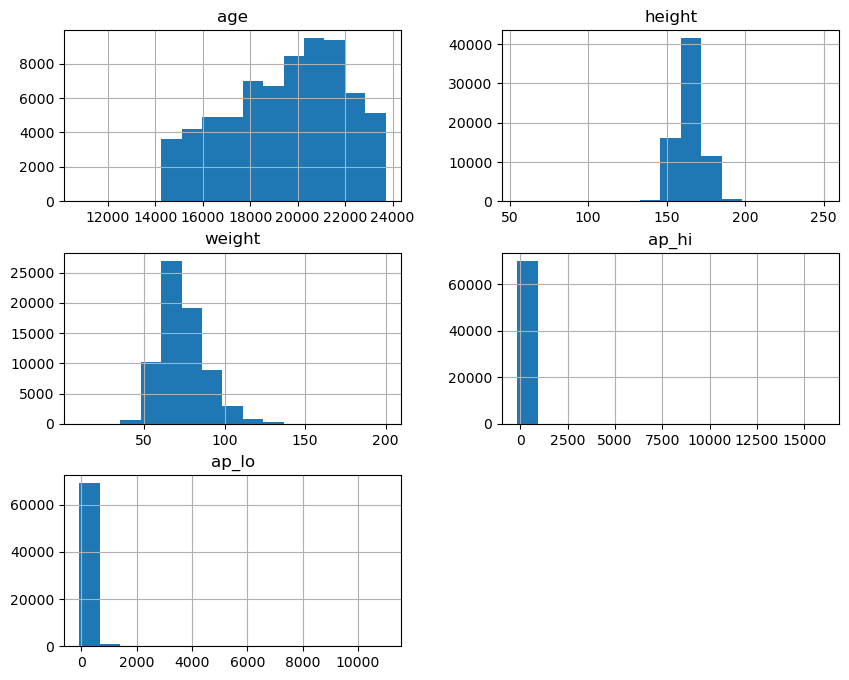

In [24]:
# Histograms showing distribution of each numerical columns
df[numerical_cols_list].hist(bins=15,figsize=(10,8))
plt.show()

In [25]:
# Correlation matrix for numerical columns
correlation = numerical_cols.drop('cardio',axis=1).corr()
correlation

,age,height,weight,ap_hi,ap_lo
age,1.000000,-0.081515,0.053684,0.020764,0.017647
height,-0.081515,1.000000,0.290968,0.005488,0.006150
weight,0.053684,0.290968,1.000000,0.030702,0.043710
ap_hi,0.020764,0.005488,0.030702,1.000000,0.016086
ap_lo,0.017647,0.006150,0.043710,0.016086,1.000000


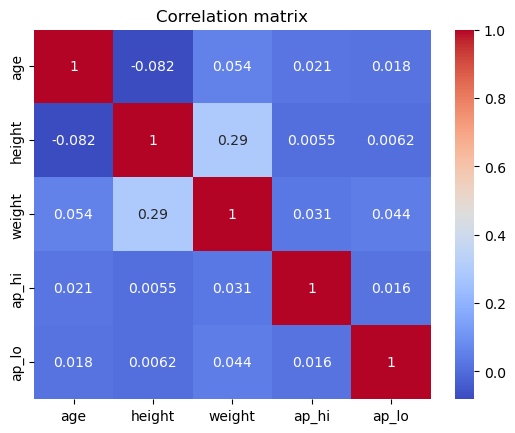

In [26]:
sns.heatmap(correlation,annot=True,cmap='coolwarm')
plt.title("Correlation matrix")
plt.show()

1. Height and Weight (0.29):
- There is a moderate positive correlation (0.29) between height and weight, indicating that taller individuals tend to have higher weights. This is the strongest correlation observed in this matrix.

2. Other Variables and Weak Correlations:
- The rest of the correlations between variables are quite low, suggesting minimal linear relationships between these features. For example, `age` shows weak correlations with all other variables, with the highest correlation being only 0.054 with `weight`. This means `age` does not have a strong linear relationship with other variables in this dataset.
- Blood Pressure Variables (`ap_hi` and `ap_lo`) also show low correlations with each other (0.016), which is unusual, as systolic and diastolic blood pressures are often expected to be correlated. This low correlation might suggest inconsistencies in data recording or could indicate that these variables are independent in this specific dataset.

3. No Strong Predictors:
- The lack of strong correlations suggests that none of these variables alone has a significant linear relationship with others. This could imply that these features may contribute only weakly to each other in terms of prediction if using linear models.

**Note**: Given the weak relationships, this dataset might benefit from more complex, non-linear analysis techniques, as linear models may not capture significant patterns effectively.

Therefore the choice is to test
1. Decision tree
2. Random forest
3. XGBoost

The best performing model will be based on the best prediction performance.

In [28]:
# Analyzing categorical Features
categorical_cols = list(df.select_dtypes(include=['object']).columns.values)
categorical_cols.append('cardio')
categorical_cols

['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']

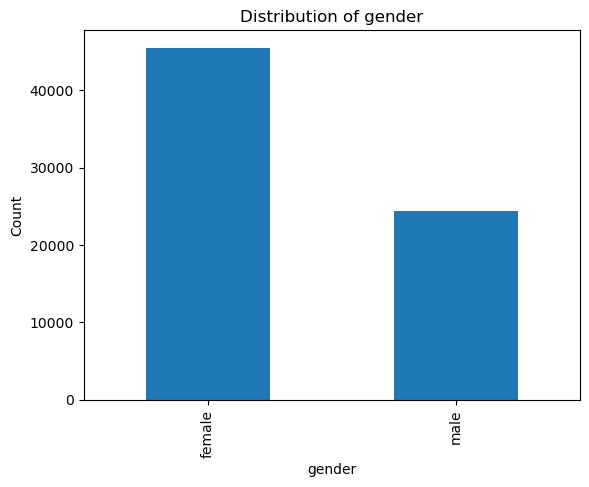

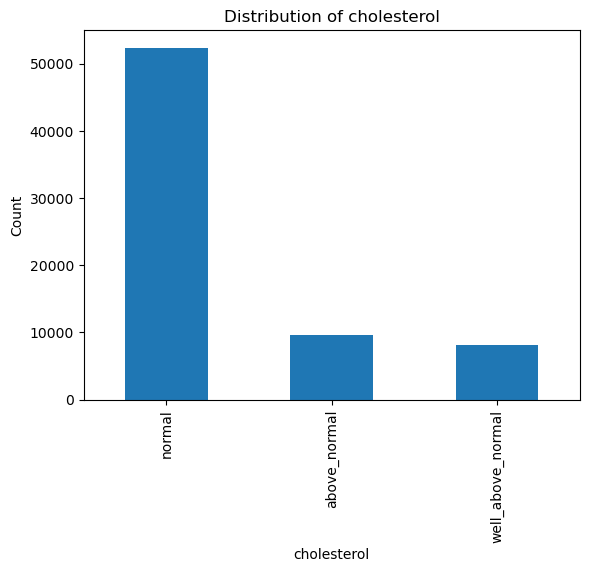

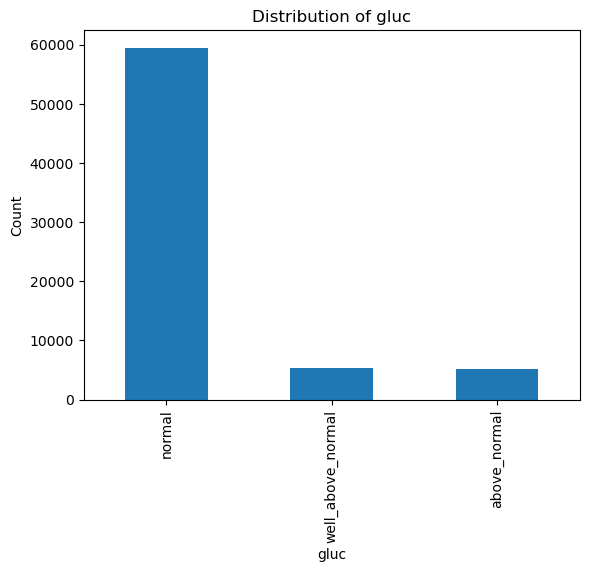

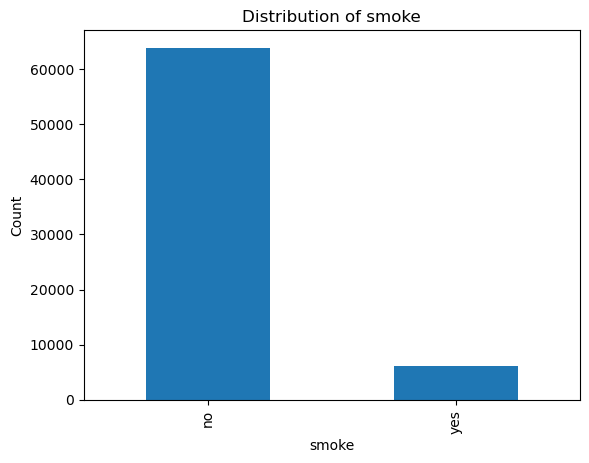

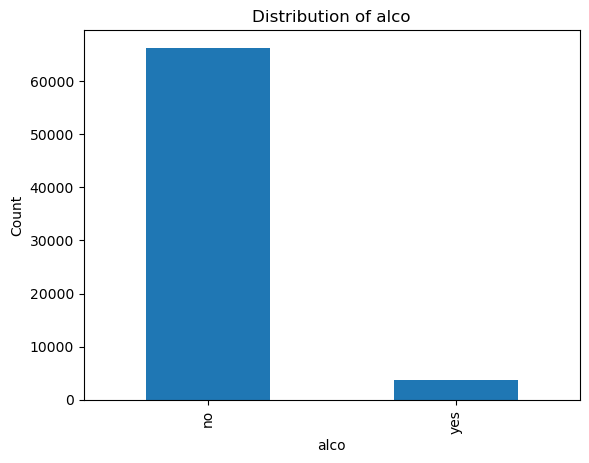

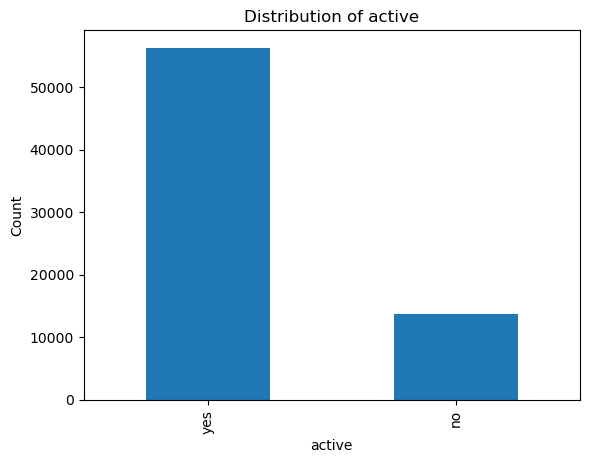

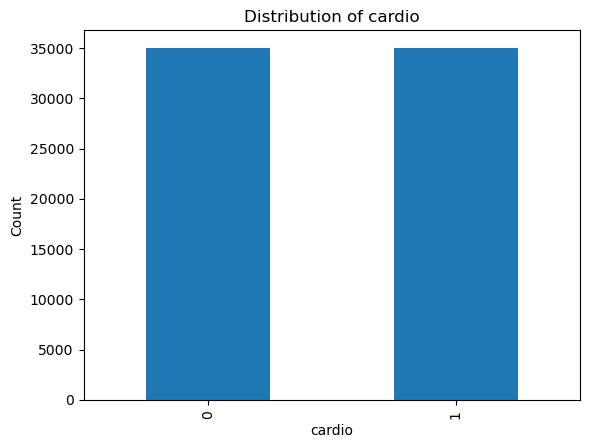

In [29]:
# Plot barcharts for categorical features
for col in categorical_cols:
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

## Data Pre-processing
Split dataset into
1. Full Training dataset (80% of dataset) 
2. Training dataset (60% of Dataset)
3. Validation set (20% of Dataset)
4. Testing set (20% of Dataset)

In [31]:
df_full_train,df_test = train_test_split(df,test_size=0.2,random_state=1,shuffle=True)
df_train,df_val = train_test_split(df_full_train,test_size=0.25,random_state=1,shuffle=True)

In [32]:
df_full_train.shape,df_train.shape,df_val.shape,df_test.shape

((56000, 12), (42000, 12), (14000, 12), (14000, 12))

In [33]:
# Define Training features and prediction values
y_train = df_train.cardio.values
y_val = df_val.cardio.values
y_test = df_test.cardio.values

df_train = df_train.drop('cardio',axis=1)
df_val = df_val.drop('cardio',axis=1)
df_test = df_test.drop('cardio',axis=1)

### Onehot encoding
- `X_train` - Feature matrix
- `X_val` - Validation matrix
- `y_train` - training target vairable
- `y_val` - validation target vairable
- `y_test` - testing target vairable

In [35]:
dict_train = df_train.to_dict(orient='records')
dict_val = df_val.to_dict(orient='records')

In [36]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dict_train)
X_val = dv.fit_transform(dict_val)

### Decision Trees

In [38]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

DecisionTreeClassifier()

In [39]:
y_pred = dt.predict_proba(X_train)[:,1]
roc_auc_score(y_train,y_pred)

0.9999999716549576

In [40]:
y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val,y_pred)

0.6332665098151775

Overfitting detected

#### Decision tree Parameter tuning
1. `max_depth` - Control the maximum depth of the tree, minimizing complex patterns that might overfit the data
2. `min_samples_split`- Minimum number of samples required to split the internal node
3. `min_samples_leaf` - Minimum number of samples required to split an internal node

In [43]:
max_depths = np.arange(1,20,1)
scores = []
for depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=depth,)
    dt.fit(X_train,y_train)
    y_pred = dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val,y_pred)
    scores.append((depth,auc))

In [44]:
df_scores = pd.DataFrame(scores,columns=['depth','auc'])
df_scores.sort_values('auc',ascending=False)

,depth,auc
5,6,0.789253
4,5,0.788061
6,7,0.787631
7,8,0.785886
3,4,0.784077
8,9,0.783084
9,10,0.779242
2,3,0.775494
10,11,0.766626
1,2,0.764334


Text(0, 0.5, 'ROC area under curve')

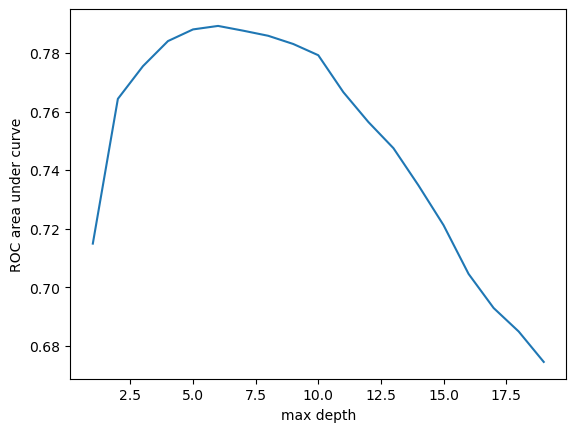

In [45]:
plt.plot(df_scores.depth,df_scores.auc)
plt.xlabel('max depth')
plt.ylabel('ROC area under curve')

Best max_depth - 6 prediction - 0.789253

In [47]:
min_samples = np.arange(1,200,1)
scores = []
for leaf in min_samples:
    dt = DecisionTreeClassifier(max_depth=6,min_samples_leaf=leaf)
    dt.fit(X_train,y_train)
    y_pred = dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val,y_pred)
    scores.append((leaf,6,auc))

In [48]:
df_scores = pd.DataFrame(scores,columns=['leaf','depth','auc'])

In [49]:
df_scores.sort_values('auc',ascending=False)

,leaf,depth,auc
174,175,6,0.791076
171,172,6,0.791076
168,169,6,0.791074
169,170,6,0.791065
170,171,6,0.791065
...,...,...,...
1,2,6,0.789253
0,1,6,0.789253
2,3,6,0.789238
3,4,6,0.789138


Best Max Samples Leaf - 172, prediction - 0.791076

In [51]:
dt = DecisionTreeClassifier(max_depth=6,min_samples_leaf=172)
dt.fit(X_train,y_train)
y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val,y_pred)

0.7910756368020255

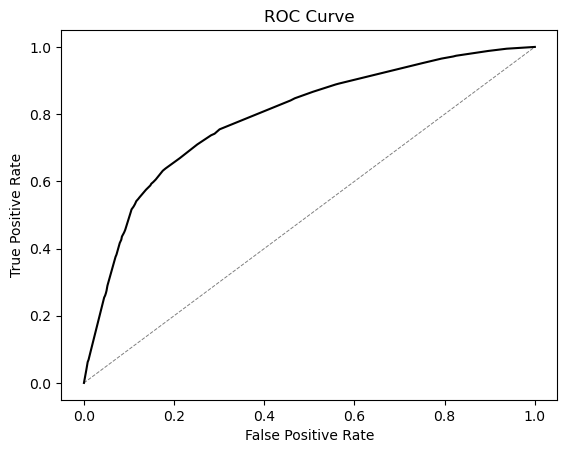

In [52]:
fpr,tpr,_ = roc_curve(y_val,y_pred)
plt.plot(fpr,tpr,color='black')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### Random Forest
- `rf` - Random Forest classifier instance
- `n_estimators` - Number of trees in the forest
- `n_jobs` - The number of jobs to run in parallel
- `max_depth` - The maximum depth of the tree.
- `min_leaf_size` - The minimum number of samples required to be at a leaf node. 

In [54]:
rf = RandomForestClassifier(n_estimators=10,n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=10, n_jobs=-1)

In [55]:
y_pred = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val,y_pred)

0.7476215945985747

In [56]:
aucs = []

for i in range(10,201,10):
    rf = RandomForestClassifier(n_estimators=i,n_jobs=-1)
    rf.fit(X_train,y_train)
    y_pred = rf.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val,y_pred)
    aucs.append((i,auc))

In [57]:
df_aucs= pd.DataFrame(aucs,columns=['n_estimator','auc'])
df_aucs.sort_values('auc',ascending=False)

,n_estimator,auc
13,140,0.771402
15,160,0.771389
16,170,0.771285
19,200,0.771236
18,190,0.771180
11,120,0.770871
12,130,0.770796
17,180,0.770735
14,150,0.770685
10,110,0.770414


Best N Estimator value - 190

Text(0.5, 1.0, 'Number of trees vs. AUC')

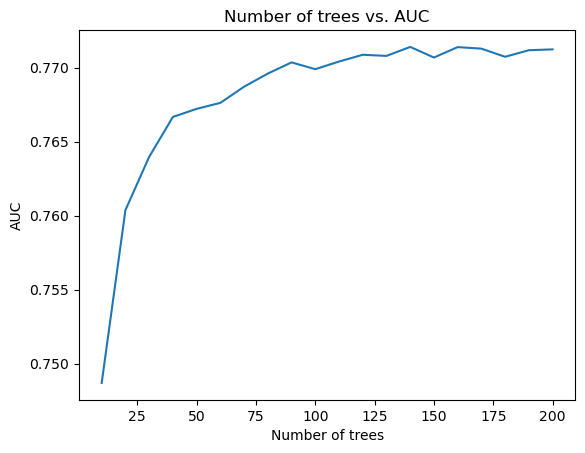

In [59]:
# Visualizing the n_estimatoes
plt.plot(df_aucs.n_estimator,df_aucs.auc)
plt.xlabel('Number of trees')
plt.ylabel('AUC')
plt.title('Number of trees vs. AUC')

##### parameter tuning - Random forest
- `max_depth`
- `min_leaf_size`

In [61]:
auc_cal = {}

for depth in range(2,11,2):
    print(f'depth: {depth}')
    aucs = []
    for i in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=i,n_jobs=-1,max_depth=depth,random_state=1)
        rf.fit(X_train,y_train)
        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val,y_pred)
        aucs.append((auc))
    auc_cal[depth] = aucs

depth: 2
depth: 4
depth: 6
depth: 8
depth: 10


In [62]:
auc_cal

{2: [0.7817174054376709,
  0.7848590781534137,
  0.7842675788935071,
  0.7842768953691015,
  0.7848513025187993,
  0.784649493167401,
  0.7840238198913223,
  0.78321021503691,
  0.7827197173930294,
  0.7825965419528345,
  0.7831234279340306,
  0.7831644081815513,
  0.7835045972980466,
  0.783429320583415,
  0.7836003641364384,
  0.7831316423511757,
  0.7827813408279838,
  0.7829141592796096,
  0.7828602094368204,
  0.7828887507098072],
 4: [0.7854709144734071,
  0.7875124981591543,
  0.788509677379328,
  0.7901166724790046,
  0.7898707093599211,
  0.789891577040743,
  0.7901623160664448,
  0.7899110059230334,
  0.7897712894018549,
  0.7901378564914182,
  0.790041497806822,
  0.7898454436495473,
  0.7897494217050329,
  0.7897417889298475,
  0.7896969820904889,
  0.789538428533224,
  0.7895700412839258,
  0.789641573040679,
  0.7897081353301654,
  0.7898327495688912],
 6: [0.7931564660136603,
  0.7940059081761633,
  0.7943511075769049,
  0.7954389719215098,
  0.7957673649309002,
  0.7958

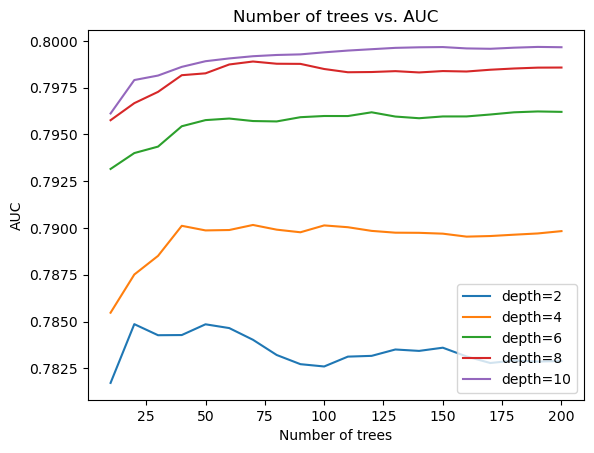

In [63]:
n_trees = list(range(10,201,10))
for i,_ in auc_cal.items():
    plt.plot(n_trees,auc_cal[i],label='depth=%s'% i)
    plt.xlabel('Number of trees')
    plt.ylabel('AUC')
    plt.title('Number of trees vs. AUC')
    plt.legend()

Best `max_depth` = 10 with auc about `79.99%`

In [189]:
auc_cal = {}

for m in [10,6,7]:
    print(f'min_samples_leaf: {m}')
    aucs = []
    for i in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=i,n_jobs=-1,max_depth=10,random_state=1,min_samples_leaf=m)
        rf.fit(X_train,y_train)
        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val,y_pred)
        aucs.append((auc))
    auc_cal[m] = aucs

min_samples_leaf: 10
min_samples_leaf: 6
min_samples_leaf: 7


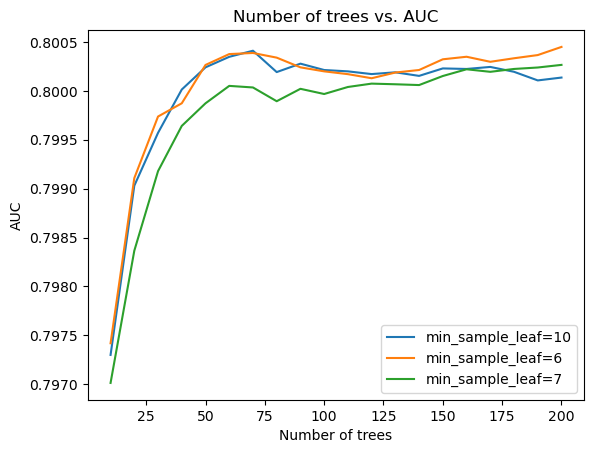

In [190]:
n_trees = list(range(10,201,10))
for i in list(auc_cal.keys()):
    plt.plot(n_trees,auc_cal[i],label='min_sample_leaf=%s'% i)
    plt.xlabel('Number of trees')
    plt.ylabel('AUC')
    plt.title('Number of trees vs. AUC')
    plt.legend()

In [193]:
df_aucs_rf = pd.DataFrame(auc_cal)
df_aucs_rf.sort_values(by=[10,6,7],ascending=False)

,10,6,7
6,0.800411,0.800388,0.800035
5,0.800348,0.800376,0.800051
8,0.800278,0.800241,0.800021
16,0.800245,0.800298,0.800195
4,0.800241,0.800265,0.799873
14,0.800230,0.800323,0.800152
15,0.800224,0.800349,0.800221
9,0.800213,0.800200,0.799968
10,0.800200,0.800171,0.800040
17,0.800195,0.800334,0.800224


Random Forest Parameters
- `max_depth` - 10
- `n_estimators` - 200
- `min_samples_leaf` - 6

In [208]:
# Final Random Forest model
rf = RandomForestClassifier(n_estimators=200,n_jobs=-1,max_depth=10,random_state=1,min_samples_leaf=6)
rf.fit(X_train,y_train)
y_pred = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val,y_pred)

0.8004495929077722

#### Gradient Boosting with XG-BOOST
I will combine multiple models together in an ensemble.

- `dtrain` - Training dataset
- `xgb_params` - Training parameters
- `num_boost_round`- Number of trees to train 

In [223]:
dtrain = xgboost.DMatrix(X_train,label=y_train,feature_names=list(dv.get_feature_names_out()))
dval = xgboost.DMatrix(X_val,label=y_val,feature_names=list(dv.get_feature_names_out()))

In [238]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1,
}

In [240]:
model = xgboost.train(xgb_params,dtrain,num_boost_round=10)

In [252]:
y_pred = model.predict(dval)
roc_auc_score(y_val,y_pred)

0.798733463408884

Parameter tunning **XGBoost**

To monitor AUC changes, I will use a watchlist `watchlist = [(dtrain, 'train'), (dval, 'val')]`

In [256]:
watchlist = [(dtrain, 'train'), (dval, 'val')]